# Data Understanding

The development data is split into 7 files, each with some table of a relational model. Let's start creating a function that reads one of the files and creates a DataFrame with its data.

In [8]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

# displays plots in the notebook
%matplotlib inline

def read_frame(name: str) -> pd.DataFrame:
    return pd.read_csv('../data/preprocessed/' + name + '.csv', sep=';')

## Loans

Now we can read the main file, the loans file, and show its first rows so we know which information it has.

In [68]:
loans = read_frame('loan_dev')
loans.head()

,loan_id,account_id,amount,duration,payments,status,loan_year,loan_month,loan_day,loan_date
0,5314,1787,96396,12,8033,-1,1993,7,5,1993-07-05
1,5316,1801,165960,36,4610,1,1993,7,11,1993-07-11
2,6863,9188,127080,60,2118,1,1993,7,28,1993-07-28
3,5325,1843,105804,36,2939,1,1993,8,3,1993-08-03
4,7240,11013,274740,60,4579,1,1993,9,6,1993-09-06


Now let's do some analysis of the attributes, starting with the loan_id and account_id, the dataset should have no duplicated loans, but two loans of the same account are allowed.

In [3]:
print('There are', '' if loans.loan_id.duplicated().any() else 'no', 'duplicated loans.')
print('There are', '' if loans.account_id.duplicated().any() else 'no', 'accounts that have started two loans.')

There are no duplicated loans.
There are no accounts that have started two loans.


### Heatmap

We can start with a heatmap of the attributes of loans to see if we can visualize relationships between attributes

<AxesSubplot:>

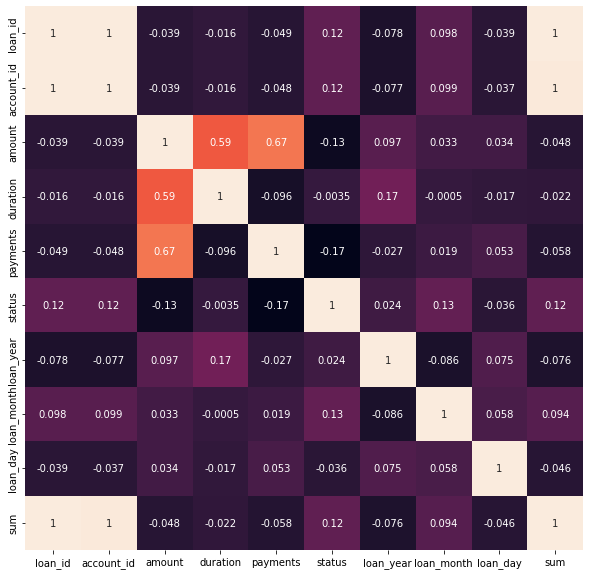

In [63]:
plt.figure(figsize=(10, 10))
sns.heatmap(loans.corr(), annot=True, cbar=False)

As we can see the duration, amount and payments variables are related, as expected, because everything goes right with the loan payment, they should create a formula that only depends on the interest rate.

The status is inversely proportional to the payments and amount attributes, it also makes sense, as larger loans are harder to be paid.

The coeficients of the other pairs of attributes do not show any big correlations.

### Distributions

So let's analyse the distribution of values for amount and payments with two histograms.

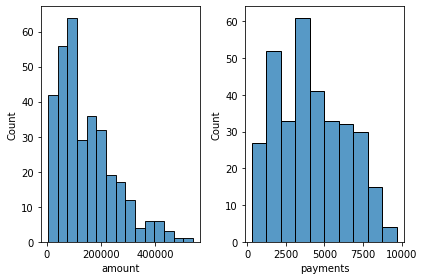

In [6]:
fig, ax = plt.subplots(1,2)

# Create the graphics
sns.histplot(data=loans, x='amount', ax=ax[0])
sns.histplot(data=loans, x='payments', ax=ax[1])

# Display the figures in a nice way
fig.tight_layout()

We can also see the valid values for duration.

In [7]:
print("The values for duration are:", *loans.duration.unique().tolist())

The values for duration are: 12 36 60 24 48


As we can see, all the valid durations are a multiple of 12, so they are written in months but need to be a multiple of a year, we can convert them to years just to better visualize the values.

<AxesSubplot:xlabel='duration', ylabel='Count'>

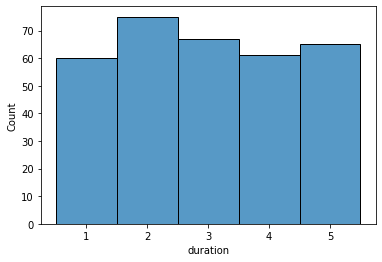

In [9]:
loans.duration = (loans.duration / 12).astype('int')
sns.histplot(data=loans, x='duration', discrete=True)

The values for the duration are very balanced.

## Disp

In [11]:
disp = read_frame("disp")
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,owner
1,2,2,2,owner
2,3,3,2,disponent
3,4,4,3,owner
4,5,5,3,disponent


Let's analyse some attributes.  
- Let's check for repeated values in `disp_id`, `account_id` and `client_id` to check for wrong data, since the relation between `client_id` and `disp_id` should be one to one, and the relation between `account_id` and `client_id` should be one to many.  
- We will also check the how many clients are really owners of their account.

In [51]:
print("Duplicates in disp_id:\t\t%d" %disp['disp_id'].duplicated().any())
print("Duplicates in client_id:\t%d" %disp['client_id'].duplicated().any())
print("Duplicates in account_id:\t%d" %disp['account_id'].duplicated().any())

is_owner = disp['type'].str.count("owner")
print("Owner:\t\t\t\t%d" %(is_owner.sum()))
print("Disponent:\t\t\t%d" %(is_owner.count() - is_owner.sum()))

Duplicates in disp_id:		0
Duplicates in client_id:	0
Duplicates in account_id:	1
Owner:				4500
Disponent:			869


By having duplicates in `account_id`, we confirm that an account may represent many clients and that there're no errors in the `disp_id` and `client_id` columns. 

### Heatmap
To analyse the heatmap for the disp, we need to merge the relevant fields in `loans` and `disp`

In [88]:
loans_ = loans[['account_id', 'status']]
merge_disp_loans = loans_.merge(right=disp, how='inner', on='account_id')
print(merge_disp_loans.head())

   account_id  status  disp_id  client_id  type
0        1787      -1     2166       2166     0
1        1801       1     2181       2181     0
2        9188       1    11006      11314     0
3        1843       1     2235       2235     0
4       11013       1    13231      13539     0


To also include the `type` in the heatmap, we must change this value to integer.

In [89]:
merge_disp_loans['type'] = disp['type'].replace('owner', 0)
merge_disp_loans['type'] = disp['type'].replace('disponent', 1)
print(merge_disp_loans.head())

   account_id  status  disp_id  client_id  type
0        1787      -1     2166       2166     0
1        1801       1     2181       2181     0
2        9188       1    11006      11314     1
3        1843       1     2235       2235     0
4       11013       1    13231      13539     1


<AxesSubplot:>

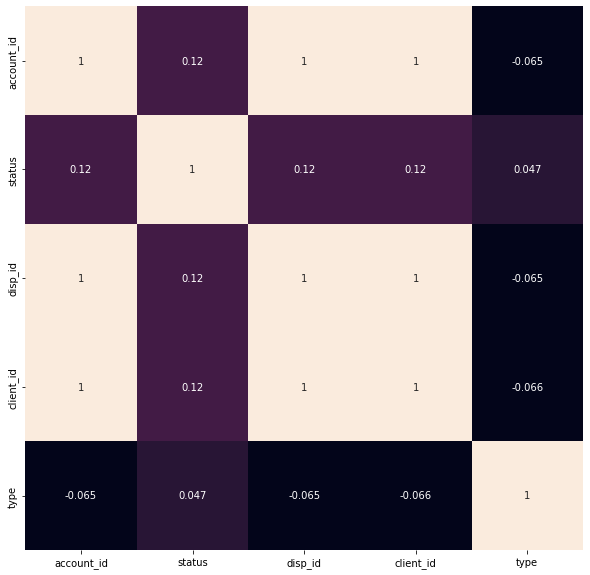

In [90]:
plt.figure(figsize=(10, 10))
sns.heatmap(merge_disp_loans.corr(), annot=True, cbar=False)